# Pick and Place in PyBullet

This tutorial shows how to attach a two fingered jaw gripper to the Kuka robot
to pick-and-place objects.

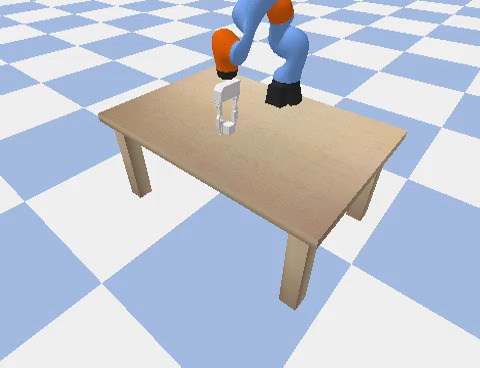

In [2]:
import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

pybullet build time: Sep  3 2024 13:18:06


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 360) to (480, 368) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


timestep 749...

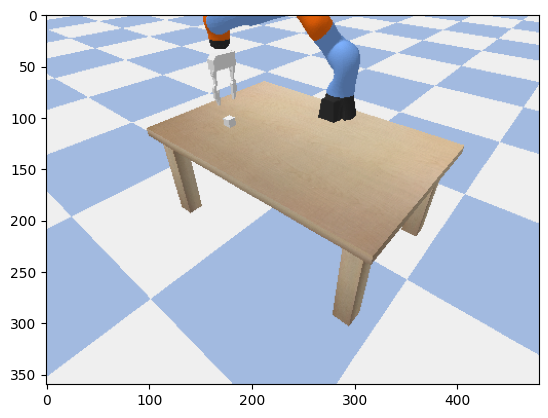

In [3]:
p.connect(p.DIRECT)  # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

plane_id = p.loadURDF("plane.urdf")
kuka_id = p.loadURDF(
    "kuka_iiwa/model_vr_limits.urdf",
    1.400000,
    -0.200000,
    0.600000,
    0.000000,
    0.000000,
    0.000000,
    1.000000,
)
kuka_gripper_id = p.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]
table_id = p.loadURDF(
    "table/table.urdf",
    basePosition=[1.0, -0.2, 0.0],
    baseOrientation=[0, 0, 0.7071, 0.7071],
)
cube_id = p.loadURDF("cube.urdf", basePosition=[0.85, -0.2, 0.65], globalScaling=0.05)

# attach gripper to kuka arm
kuka_cid = p.createConstraint(
    kuka_id, 6, kuka_gripper_id, 0, p.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0]
)
kuka_cid2 = p.createConstraint(
    kuka_gripper_id,
    4,
    kuka_gripper_id,
    6,
    jointType=p.JOINT_GEAR,
    jointAxis=[1, 1, 1],
    parentFramePosition=[0, 0, 0],
    childFramePosition=[0, 0, 0],
)
p.changeConstraint(
    kuka_cid2, gearRatio=-1, erp=0.5, relativePositionTarget=0, maxForce=100
)

# reset kuka
jointPositions = [
    -0.000000,
    -0.000000,
    0.000000,
    1.570793,
    0.000000,
    -1.036725,
    0.000001,
]
for jointIndex in range(p.getNumJoints(kuka_id)):
    p.resetJointState(kuka_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(
        kuka_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0
    )

# reset gripper
p.resetBasePositionAndOrientation(
    kuka_gripper_id,
    [0.923103, -0.200000, 1.250036],
    [-0.000000, 0.964531, -0.000002, -0.263970],
)
jointPositions = [
    0.000000,
    -0.011130,
    -0.206421,
    0.205143,
    -0.009999,
    0.000000,
    -0.010055,
    0.000000,
]
for jointIndex in range(p.getNumJoints(kuka_gripper_id)):
    p.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(
        kuka_gripper_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0
    )

num_joints = p.getNumJoints(kuka_id)
kuka_end_effector_idx = 6

# camera parameters
cam_target_pos = [0.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = (
    [0, 0, 1],
    2,
    0.01,
    100,
    60,
)

# video = cv2.VideoWriter('vid.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (cam_width, cam_height)) # Does not seem to support h264!
vid = imageio_ffmpeg.write_frames("vid.mp4", (cam_width, cam_height), fps=30)
vid.send(None)  # seed the video writer with a blank frame

for t in range(750):
    print(f"\rtimestep {t}...", end="")

    if (
        t % 8 == 0
    ):  # PyBullet default simulation time step is 240fps, but we want to record video at 30fps.
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
            cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
        )
        cam_projection_matrix = p.computeProjectionMatrixFOV(
            cam_fov, cam_width * 1.0 / cam_height, cam_near_plane, cam_far_plane
        )
        image = p.getCameraImage(
            cam_width, cam_height, cam_view_matrix, cam_projection_matrix
        )[2][:, :, :3]
        # video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        vid.send(np.ascontiguousarray(image))

    target_pos, gripper_val = [0.85, -0.2, 0.97], 0
    if t >= 150 and t < 250:
        target_pos, gripper_val = [0.85, -0.2, 0.97], 1  # grab object
    elif t >= 250 and t < 400:
        target_pos, gripper_val = (
            [0.85, -0.2, 0.97 + 0.13 * (t - 250) / 150.0],
            1,
        )  # move up after picking object
    elif t >= 400 and t < 600:
        target_pos, gripper_val = (
            [0.85, -0.2 + 0.4 * (t - 400) / 200.0, 1.1],
            1,
        )  # move to target position
    elif t >= 600 and t < 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 1  # stop at target position
    elif t >= 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 0  # drop object

    target_orn = p.getQuaternionFromEuler([0, 1.01 * math.pi, 0])
    joint_poses = p.calculateInverseKinematics(
        kuka_id, kuka_end_effector_idx, target_pos, target_orn
    )
    for j in range(num_joints):
        p.setJointMotorControl2(
            bodyIndex=kuka_id,
            jointIndex=j,
            controlMode=p.POSITION_CONTROL,
            targetPosition=joint_poses[j],
        )

    p.setJointMotorControl2(
        kuka_gripper_id,
        4,
        p.POSITION_CONTROL,
        targetPosition=gripper_val * 0.05,
        force=100,
    )
    p.setJointMotorControl2(
        kuka_gripper_id,
        6,
        p.POSITION_CONTROL,
        targetPosition=gripper_val * 0.05,
        force=100,
    )

    p.stepSimulation()

plt.imshow(Image.fromarray(image))  # show the last frame

vid.close()
# video.release()
p.disconnect()

In [4]:
# Play recorded video

# os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open("vid.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)